# Example of how to make calculation on ROMS output datasets using xgcm

In [1]:
import xarray as xr
from xgcm import Grid
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
from IPython.display import Image

In [2]:
model_path = 'http://barataria.tamu.edu:8080/thredds/dodsC/NcML/txla_hindcast_agg'
ds = xr.open_dataset(model_path, chunks={'ocean_time': 1}).sel(ocean_time='2018-02')
# ds = xr.open_dataset('/d2/shared/TXLA_ROMS/output_20yr_obc/2018/ocean_his_0001.nc', chunks={'ocean_time': 1}, decode_coords=True)

Typical coordinates in ROMS include tracer (rho), velocity (u and v) and corner (psi) points.

In [3]:
ds.coords

Coordinates:
  * s_rho       (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
  * s_w         (s_w) float64 -1.0 -0.9667 -0.9333 ... -0.06667 -0.03333 0.0
    lon_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(191, 671), meta=np.ndarray>
    lat_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(191, 671), meta=np.ndarray>
    lon_u       (eta_u, xi_u) float64 dask.array<chunksize=(191, 670), meta=np.ndarray>
    lat_u       (eta_u, xi_u) float64 dask.array<chunksize=(191, 670), meta=np.ndarray>
    lon_v       (eta_v, xi_v) float64 dask.array<chunksize=(190, 671), meta=np.ndarray>
    lat_v       (eta_v, xi_v) float64 dask.array<chunksize=(190, 671), meta=np.ndarray>
    lon_psi     (eta_psi, xi_psi) float64 dask.array<chunksize=(190, 670), meta=np.ndarray>
    lat_psi     (eta_psi, xi_psi) float64 dask.array<chunksize=(190, 670), meta=np.ndarray>
  * ocean_time  (ocean_time) datetime64[ns] 2018-02-01 ... 2018-02-28T23:00:00

# ROMS grid
ROMS uses an Arakawa C-grid. Following xgcm grid topology, rho points are at a center position and u and v points are at inner position in the xi and etha direction repectively.
![ROMS grid](https://www.myroms.org/wiki/images/0/0a/Whole_grid.png)

# Creating a grid object
While xgcm doesn't currently have an implementation for the SGRID convention for ROMS, a workaround consist on renaming eta_u and xi_v dimensions to rho. With this replacement 'psi' points have now a position (eta_v, xi_u). See issue [here](https://github.com/xgcm/xgcm/issues/108).

In [4]:
ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

coords={'xi':{'center':'xi_rho', 'inner':'xi_u'}, 
    'eta':{'center':'eta_rho', 'inner':'eta_v'}, 
    's':{'center':'s_rho', 'outer':'s_w'}}

grid = Grid(ds, coords=coords, periodic=[])

In [5]:
grid

<xgcm.Grid>
xi Axis (not periodic):
  * center   xi_rho --> inner
  * inner    xi_u --> center
eta Axis (not periodic):
  * center   eta_rho --> inner
  * inner    eta_v --> center
s Axis (not periodic):
  * center   s_rho --> outer
  * outer    s_w --> center

# Lazy calculations: vorticity
Using chunks allows to use dask capability using xgcm metrics on xarray. Here an example to calculate vorticity.

In [6]:
ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'eta'),  'xi') # at psi points (eta_v, xi_u) 
ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'xi'),  'eta') # at psi points (eta_v, xi_u)
ds['dudy'] = grid.diff(ds.u, 'eta')*ds['pn_psi']
ds['dvdx'] = grid.diff(ds.v, 'xi')*ds['pm_psi']
ds['f_psi'] = grid.interp(grid.interp(ds.f, 'eta'),  'xi')

Calculated variables above are reasigned to parent dataset to preserve coordinates (see isabove sabove ue [here](https://github.com/xgcm/xgcm/issues/150#issuecomment-537069055))

In [7]:
vor = ds['dvdx'] - ds['dudy']
rvor = vor/ds['f_psi'] # normalized vorticity

In [8]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

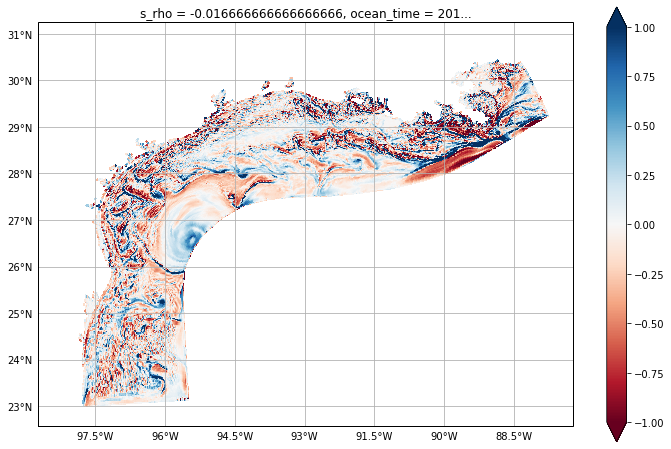

In [9]:
fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection=ccrs.PlateCarree())
rvor.sel(ocean_time='2018-02-15T12').isel(s_rho=-1).plot(ax=ax, transform=ccrs.PlateCarree(), 
                                        x='lon_psi', y='lat_psi', 
                                        vmin=-1, vmax=1, cmap='RdBu')
gl = ax.gridlines(draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = gl.ylabels_right = False

In [10]:
rvor

<xarray.DataArray (ocean_time: 672, s_rho: 30, eta_v: 190, xi_u: 670)>
dask.array<truediv, shape=(672, 30, 190, 670), dtype=float64, chunksize=(1, 30, 190, 670)>
Coordinates:
  * s_rho       (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
    lon_psi     (eta_v, xi_u) float64 -95.49 -95.49 -95.49 ... -88.88 -88.87
    lat_psi     (eta_v, xi_u) float64 23.13 23.16 23.19 ... 30.83 30.84 30.85
  * ocean_time  (ocean_time) datetime64[ns] 2018-02-01 ... 2018-02-28T23:00:00
Dimensions without coordinates: eta_v, xi_u

# ROMS vertical coordinates
To convert ROMS s coordinates to z coordinates see [here](https://www.myroms.org/wiki/Vertical_S-coordinate)
Transformation equations depend on the choice of Vtransform and Vstretching. The following equations are the implementation for Vtransform=2 and Vstretching=4.

In [11]:
Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho = Zo_rho * (ds.zeta + ds.h) + ds.zeta
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta

ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  import sys


In [12]:
# Adding the vertical coordinate
rvor.coords['z_rho_psi'] = grid.interp(grid.interp(ds.z_rho, 'xi'), 'eta')

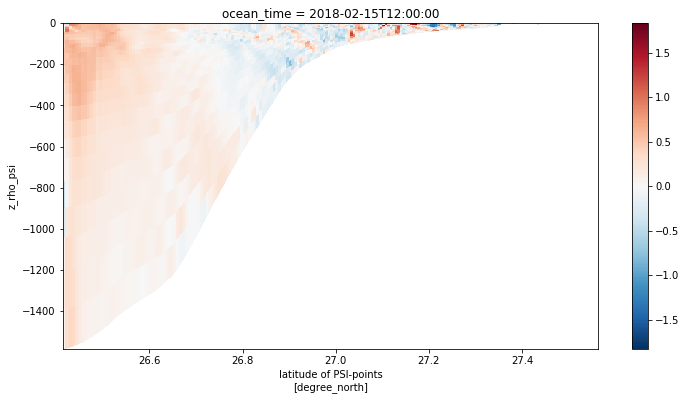

In [13]:
fig = plt.figure(figsize=(12,6))
rvor.sel(ocean_time='2018-02-15T12').sel(xi_u=150,).plot(x='lat_psi', 
                                                          y='z_rho_psi')